<h1>Minería de Datos y Modelización Predictiva II - Tarea<h1>

<h2>Analisis de Componentes Principales (PCA)<h2>

Liberias usadas:

In [18]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.discriminant_analysis import StandardScaler
from sklearn.decomposition import PCA

<h3>1 - Matriz de correlaciones entre las variables del conjunto de datos </h3>

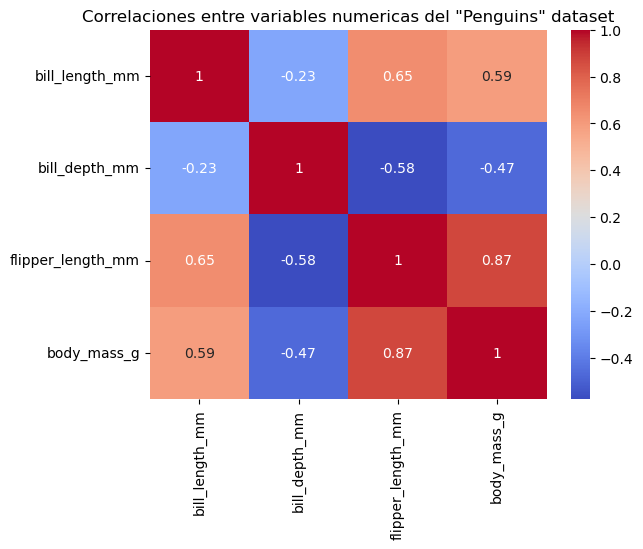

In [7]:
penguins = sns.load_dataset('penguins')

penguins = penguins.dropna()

numeric_cols = penguins.select_dtypes(include=['number']).columns
penguins_numeric_data = penguins[numeric_cols]
correlation_matrix = penguins_numeric_data.corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlaciones entre variables numericas del "Penguins" dataset')
plt.show()

Las variables mas correlacionadas son body_mass_g con flipper_length_mm, las otras relaciones se encuentran escamente correlacionadas.

<h3>2 - Analisis de componentes principales</h3>

primero hacemos la estandarización de los datos para que todas las variables esteen en la misma escala

In [11]:
data_standardized = StandardScaler().fit_transform(penguins_numeric_data)

ahora hacemos la primera seleccion de componentes pricinpales tomando como numero de componentes el total del numero de variables para retener el maximo de componentes principales y analizar la perdida de explicacion de la variabilidad del conjunto de datos con respecto a menor numero de componentes

In [16]:
pca = PCA(n_components=4)
fit = pca.fit(data_standardized)

Calculamos la variabilidad explicada de cada compoonente principal calculado. La mostramos para cada commponente junto con su autovalor y la variabilidad acumulada

In [20]:
autovalores = fit.explained_variance_

var_explicada = fit.explained_variance_ratio_
var_acumulada = np.cumsum(var_explicada)
data = {'Autovalores': autovalores, 'Variabilidad Explicada': var_explicada , 'Variabilidad Acumulada': var_acumulada}
tabla = pd.DataFrame(data, index=['Componente {}'.format(i) for i in range
 (1, fit.n_components_+1)])

print(tabla)

              Autovalores  Variabilidad Explicada  Variabilidad Acumulada
Componente 1     2.753625                0.686339                0.686339
Componente 2     0.780461                0.194529                0.880868
Componente 3     0.369753                0.092161                0.973029
Componente 4     0.108210                0.026971                1.000000


Si bien al ser tan pocas variables no hace falta mucho mas que un cuadro comparativo para decidir el numero adecuado de componentes, a fines de ser rigurosos vamos a hacer un grafico de la variabilidad explicada de cada componente ordenada de mayor a menor para decidir el numero de componentes en base a la "regla del codo"

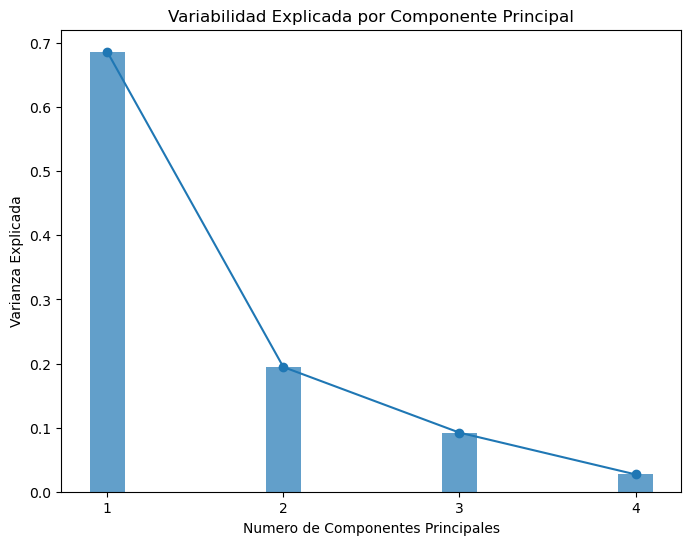

In [22]:
def plot_varianza_explicada(var_explicada, n_components):
    num_componentes_range = np.arange(1, n_components + 1)
    plt.figure(figsize=(8, 6))
    plt.plot(num_componentes_range, var_explicada, marker='o')
    plt.xlabel('Numero de Componentes Principales')
    plt.ylabel('Varianza Explicada')
    plt.title('Variabilidad Explicada por Componente Principal')
    plt.xticks(num_componentes_range)
    plt.bar(num_componentes_range, var_explicada, width=0.2, align='center', alpha=0.7)
    plt.show()
plot_varianza_explicada(var_explicada, fit.n_components_)

El numero de compoonentes principales que elegimos como indicado es 2 componentes principales ya que podemos observar que al incoporar el 3 componente principal ya no incoroporamos proporcionalmente mucha explicacion de la variabilidad y el 88% de la explicacion de la variabilidad que tenemos con 2 componentes es suficientemente significativ0 como para conforarnos con ese porcentaje y con dos componentes principales

<h3>Analisis de Componentes principales sobre la matriz de correlaciones</h3>

Ya que hemos decido quedarnos con dos componentes principales procedemos a calcular los autovectores para cada uno

In [30]:
pca = PCA(n_components=2)
fit = pca.fit(data_standardized)
autovectores = pd.DataFrame(pca.components_.T,
columns = ['Autovector {}'.format(i) for i in
    range(1, pca.n_components_+1)],
    index = ['{}_z'.format(variable) for variable
    in  list(penguins_numeric_data.columns)])

print(autovectores)

                     Autovector 1  Autovector 2
bill_length_mm_z         0.453753      0.600195
bill_depth_mm_z         -0.399047      0.796170
flipper_length_mm_z      0.576825      0.005788
body_mass_g_z            0.549675      0.076464


Ahora vamos a calcular los valores de los componentes principales para cada una de las observaciones de nuestro conjunto de datos final. Para facilitar la legibilidad vamos a mostrar solo la primera observacion con los CP calculados pero nos vamos a guardar el nuevo dataset con los CP añadidos a el (podriamos eliminar las variables originales para cada observacion retieniendo el 88% de la variabilidad del conjunto de datos original como ya enunciamos antes)

In [ ]:
data_standardized_df = pd.DataFrame(data_standardized,
                                     columns=penguins_numeric_data.columns,
                                     index=penguins_numeric_data.index)

resultados_pca = pd.DataFrame(fit.transform(data_standardized_df),
    columns=['Componente {}'.format(i) for i in
    range(1, fit.n_components_+1)],
    index=data_standardized_df.index)
data_penguins_z_cp = pd.concat([data_standardized_df, resultados_pca], axis=1)

print(data_penguins_z_cp.head(1))

   bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g  \
0       -0.896042       0.780732          -1.426752    -0.568475   

   Componente 1  Componente 2  
0     -1.853593      0.032069  


c:\Users\pablo\anaconda3\envs\mineria_de_datos_ucm\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


<h4>Inciso A</h4>

Analizemos cual es el calculo matematico que se hace para asignar los valores a los CP para la primera observacion. (el mismo procedimiento se debe hacer para todas las demas).

Cada componente principal se calcula usando los autovectores de cada uno asi como los datos de la observacion quedando asi formula para los autovectores generados en el anteultimo codigo:

<i>
CP1 =  0.453753 bill_length_mm_z − 0.399047 bill_depth_mm_z + 0.576825 flipper_length_mm_z + 0.549675 body_mass_g_z

CP2 =  0.600195 bill_length_mm_z + 0.796170 bill_depth_mm_z + 0.005788 flipper_length_mm_z + 0.076464 body_mass_g_z
</i>

En el caso de la primera observacion (correspondiente a la ultima salida de codigo) el calculo quedaria de la siguiente manera:

<i>
CP1 =  0.453753 * (-0.896042) − 0.399047 * 0.780732 + 0.576825 * (-1.426752) + 0.549675 * ( -0.568475)
CP1 = -1.85359322606

CP2 =  0.600195 * (-0.896042) + 0.796170 * 0.780732 + 0.005788 * (-1.426752) + 0.076464 * ( -0.568475)
CP2 = 0.03206955527
</i>

Como se puede ver los CPs calculados coincidence con los valores calculados por codigo que se muestran en la ultima salida

<h4>Inciso B</h4>

Vamos a analizar ahora cuando fuerte o debil es la relacion entre los componentes principales seleccionados con cada una de las variables originales

In [41]:
variables_cp = data_penguins_z_cp.columns
n_variables = fit.n_features_in_
covarianzas_var_comp = data_penguins_z_cp.cov()
covarianzas_var_comp = covarianzas_var_comp.iloc[:fit.n_features_in_, fit.n_features_in_:]
correlaciones = data_penguins_z_cp.corr()
correlaciones = correlaciones.iloc[:fit.n_features_in_, fit.n_features_in_ :]

print(correlaciones)

                   Componente 1  Componente 2
bill_length_mm         0.751829      0.529438
bill_depth_mm         -0.661186      0.702309
flipper_length_mm      0.955748      0.005106
body_mass_g            0.910762      0.067449


Es curioso ver como flipper_length_mm y body_mass_g estan altamente relaciondas positivamente con el componente 1 pero no tiene casi injerencia en el componente 2 en el caso de bill_length_mm y bill_length_mm es distinto ya que ambas tiene una correlacion mixta con ambos componentes teniendo bill_depth_mm una correlacion negativa con el componente 1.

Vamos a hacer un grafico para poder visualizar mejor la correlacion de los CP con las variables originales

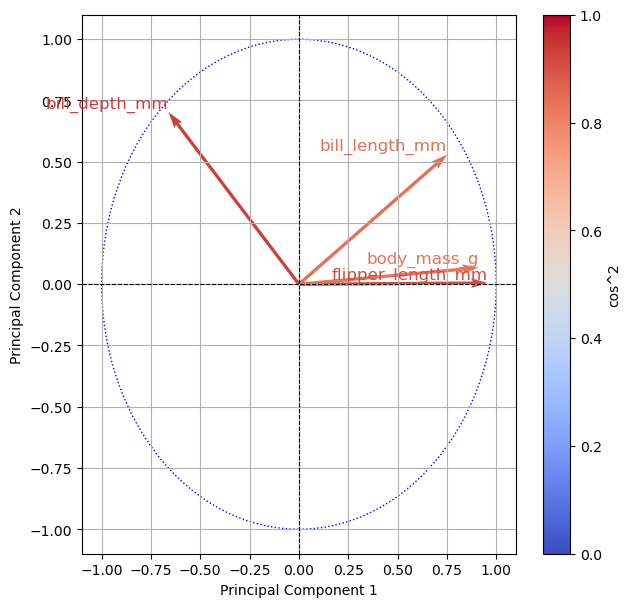

In [ ]:
def plot_corr_cos(correlations_data_with_cp):
    cmap = plt.get_cmap('coolwarm')
    _, ax = plt.subplots(figsize=(7, 7))  # Tamaño reducido
    i = 0
    j = 1
    sum_cos2 = correlations_data_with_cp.iloc[:, i] ** 2 + correlations_data_with_cp.iloc[:, j] ** 2
    circle = plt.Circle((0, 0), 1, fill=False, color='b', linestyle='dotted')
    ax.add_patch(circle)
    for k, var_name in enumerate(correlations_data_with_cp.index):
        x = correlations_data_with_cp.iloc[k, i]
        y = correlations_data_with_cp.iloc[k, j]
        color = cmap(sum_cos2.iloc[k])
        ax.quiver(0, 0, x, y, angles='xy', scale_units='xy', scale=1, color=color)
        ax.text(x, y, var_name, color=color, fontsize=12, ha='right', va='bottom')
    ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
    ax.axvline(0, color='black', linestyle='--', linewidth=0.8)
    ax.set_xlabel(f'Principal Component {i + 1}')
    ax.set_ylabel(f'Principal Component {j + 1}')
    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)
    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm.set_array([])
    plt.colorbar(sm, ax=ax, orientation='vertical', label='cos^2')
    plt.grid()
    plt.show()
plot_corr_cos(correlaciones)

El incremento de tanto longitud del pico como de la masa corporal y principalmente de la longitud de las aletas estan relacionadas con el incremento del valor del CP 1, por otro lado el increment de la profundidad del pico esta mas bien relacionada con el decremento del CP1

Para el caso del CP 2 el incremento de la profundidad del pico esta altamente relacionado con el incremento del valor del CP, en menor medida sucede lo mismo con el aumento de la longitud del pico. Con respecto a la masa corporal y la longitud de las alas no parecen un efecto significativo en el valor del CP2